# Unsupervised K - Means Clustering and Principal Component Analysis (PCA) in Python

**Author:** Ardra Charath

**Last Updated:** Nov 29, 2023

## Goal

The goal of this tutorial is to learn how to classify spectral remote sensing data using Unsupervised K-Means Clustering and Principal Component Analysis (PCA), such as for forest/vegetaion classification.

## Unsupervised K-Means

- Iterative clustering algorithm used to classify unsupervised data (does not use labeled training data) into a specified number of groups.
- Finds patterns and clusters based solely on relationship between data points and its features.

***Steps:***
1. Initializes K cluster centroids randomly
2. Each pixel in the image is assigned to the nearest cluster center
3. Centroids of the clusters are recalculated
4. Steps 2 and 3 repeat until the centroids stop changing significantly or a specified number of iterations is reached

***Limitations:***
1. The number of clusters may not be known beforehand, which can lead to suboptimal results
2. Initial placement of centroids can impact the final clustering.
3. Sensitive to outliers
4. Assumes clusters are spherical and of the same size

## Principal Component Analysis (PCA)

- Used to determine the most important patterns and relationships in the hyperspectral image bands by identifying orthogonal axes where the data varies the most, also called principal components.

***Steps:***
1. Data is centered around the mean
2. Covariance matrix of the centered data is calculated
    - Covariance – Measures how two variables change together; Higher covariance indicates a stronger relationship between the variables
3. Covariance matrix is decomposed into eigenvectors and eigenvalues
    - Eigenvectors – Represent the direction along which the data varies the most
    - Eigenvalues – Represent the magnitude of variance along the direction.
4. Eigenvectors are sorted by the value of their corresponding eigenvalues in descending order – determines order of principal components
5. Data is projected onto a subset of principal components, which reduces the original dimensionality of the data.

## Data Set Used

The data set used in this tutorial consists of visible to shortwave infrared (VSWIR) imaging spectroscopy data collected from the International Space Station (ISS), which comes from the Earth Surface Mineral Dust Source Investigation (EMIT). It focuses on the Jack and Laura Dangermond Preserve in Santa Barbara County, California.

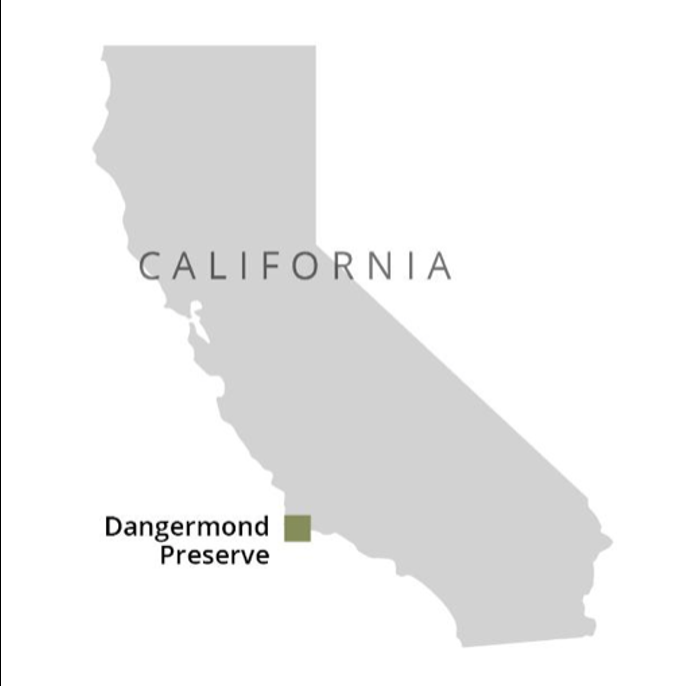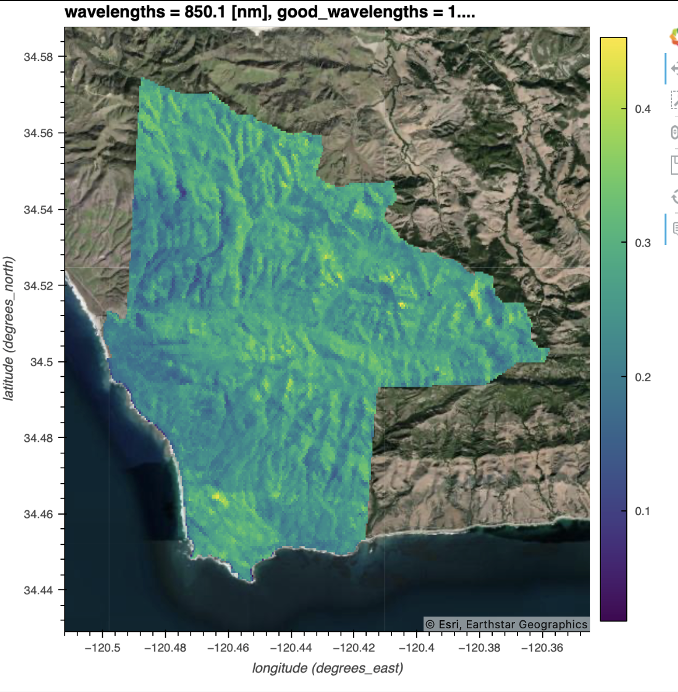

This data set was choosen because it already classifies the vegetation in the preserve, which serves as a good basis for comparison.

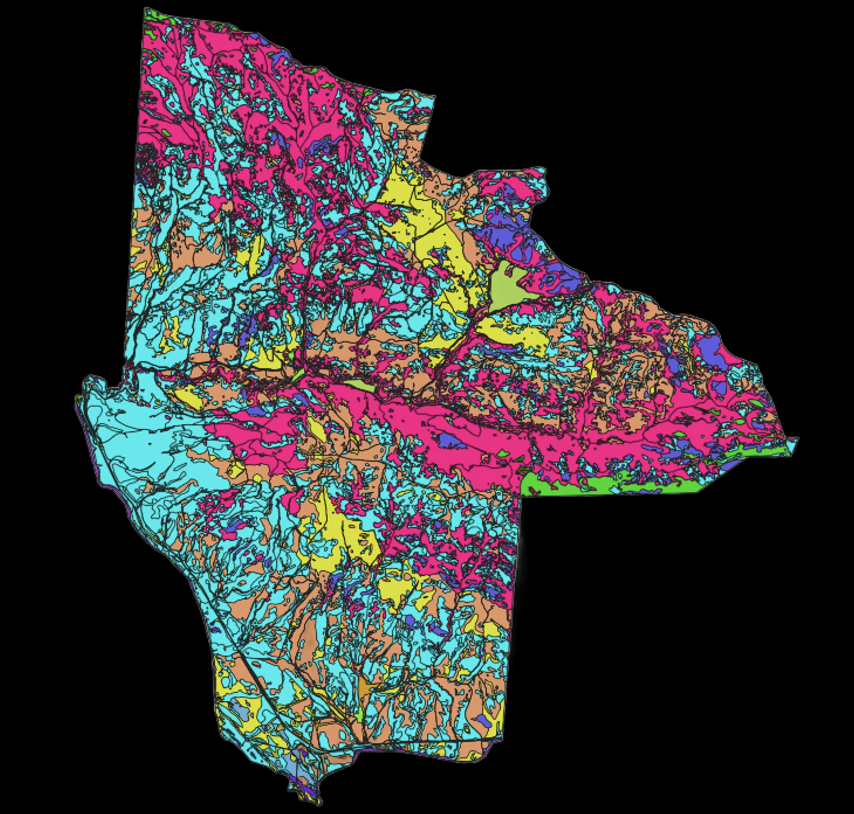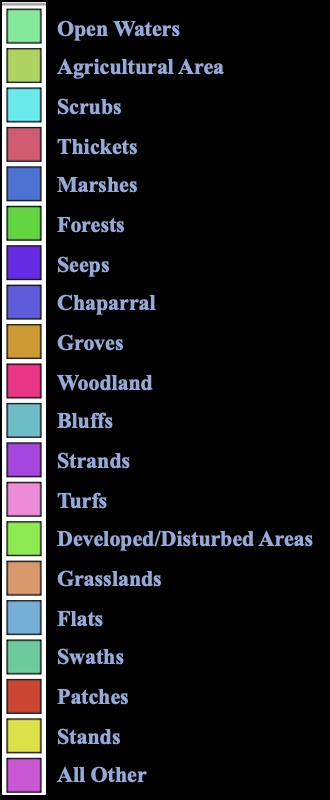

<strong>Open Waters</strong> <br>
<strong>Agricultural Area</strong> <br>
<strong>Scrubs</strong> - Purple Sage Scrub, Black Sage Scrub, Deer Weed Scrub, Coast buckwheat scrub, Coffeeberry Scrub, Menzie's Golden Bush Scrub, California Sagebrush Scrub, Giant Coreopsis Scrub, Long Leaf Bush Lupine Scrub, Bush Monkeyflower Scrub, Redberry Scrub, Lemonade Berry Scrub, Poison Oak Scrub, Silver Dune Lupine - Mock Heather Scrub, California Brittle Bush Scrub, Coyote Brush Scrub, Sawtooth Golden Bush Scrub, Silver Bush Lupine Scrub <br>
<strong>Thickets</strong> - Arroyo Willow Thickets <br>
<strong>Marshes</strong> - California Bulrush Marsh, Cattail Marshes, Baltic and Mexican Rush Marshes, & Western Rush Marshes <br>
<strong>Forests</strong> - Bishop Pine Forest & Tanoak Forest <br>
<strong>Seeps</strong> - Brownheaded Rush Seeps <br>
<strong>Chaparral</strong> - Holly Leaf Cherry Chaparral, La Purisima Manzanita Chaparral, Chamise Chaparral, Toyon Chaparral, & Buckbrush Ceanothus Chaparral <br>
<strong>Groves</strong> - Eucalyptus Groves & California Walnut Groves <br>
<strong>Woodland</strong> - Coast Live Oak Woodland <br>
<strong>Bluffs</strong> - Coastal Bluffs <br>
<strong>Strands</strong> - Coastal Strand <br>
<strong>Turfs</strong> - Creeping Ryegrass Turfs <br>
<strong>Developed/Disturbed Areas</strong> <br>
<strong>Grasslands</strong> - Non-native Grassland, Purple Needlegrass Grassland, & Giant Wild Rye Grassland <br>
<strong>Flats</strong> - Salt Grass Flats <br>
<strong>Swaths</strong> - Sand Dune Sedge Swaths <br>
<strong>Patches</strong> - Seaside Golden Yarrow Patches <br>
<strong>Stands</strong> - Semi-natural Herbaceous Stands, Semi-natural Stands, Monterey Cypress Stands, & Summer Holly Stands <br>
<strong>All Other</strong>

## Set Up and Data Acquisition

Import necessary libraries for data handling and processing

In [66]:
import earthaccess
import os
import rasterio as rio
import geopandas as gp
import sys
sys.path.append('/home/jovyan/EMIT-Data-Resources/python/modules/')
from emit_tools import emit_xarray
from spectral import *
import warnings

Suppress warnings for cleaner output (this step can be ignored).

In [67]:
warnings.filterwarnings('ignore')

Log into Earthdata for data access

In [68]:
earthaccess.login(persist=True)

We are already authenticated with NASA EDL


In [69]:
# URL for accessing the specific dataset for the tutorial
url = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230629T170449_2318011_002/EMIT_L2A_RFL_001_20230629T170449_2318011_002.nc'

In [70]:
# Initialize a session for downloading data using Earthdata login credentials
fs = earthaccess.get_fsspec_https_session()

# Extract the granule asset ID from the URL for file naming
granule_asset_id = url.split('/')[-1]

# Define the local file path for data storage
fp = f'../../data/{granule_asset_id}'
                  
# Download the data if it does not already exist locally
if not os.path.isfile(fp):
    fs.download(url, fp)

Load the dataset and apply orthorectification

In [71]:
ds_geo = emit_xarray(fp, ortho=True)

Read a shapefile to clip the dataset

In [72]:
shape = gp.read_file('/home/jovyan/EMIT-Data-Resources/python/tutorials/dangermond_boundary.shp')
img_sub = ds_geo.rio.clip(shape.geometry.values,shape.crs, all_touched=True)

In [73]:
# Zero-fill NA values
img_zero = img_sub.fillna(0)

## Unsupervised K - Means

Run the k-means algorithm and cluster the data into 19 groups using a maximum of 50 iterations.

If the algorithm terminates earlier than the 50 iterations, then the pixels are no longer being reassigned.

In [74]:
(m,c) = kmeans(img_zero.reflectance.data,19,50)

spectral:INFO: k-means iteration 1 - 33614 pixels reassigned.
spectral:INFO: k-means iteration 2 - 10904 pixels reassigned.
spectral:INFO: k-means iteration 3 - 5533 pixels reassigned.
spectral:INFO: k-means iteration 4 - 4523 pixels reassigned.
spectral:INFO: k-means iteration 5 - 3603 pixels reassigned.
spectral:INFO: k-means iteration 6 - 2876 pixels reassigned.
spectral:INFO: k-means iteration 7 - 2667 pixels reassigned.
spectral:INFO: k-means iteration 8 - 2456 pixels reassigned.
spectral:INFO: k-means iteration 9 - 2170 pixels reassigned.
spectral:INFO: k-means iteration 10 - 1853 pixels reassigned.
spectral:INFO: k-means iteration 11 - 1673 pixels reassigned.
spectral:INFO: k-means iteration 12 - 1502 pixels reassigned.
spectral:INFO: k-means iteration 13 - 1352 pixels reassigned.
spectral:INFO: k-means iteration 14 - 1293 pixels reassigned.
spectral:INFO: k-means iteration 15 - 1326 pixels reassigned.
spectral:INFO: k-means iteration 16 - 1355 pixels reassigned.
spectral:INFO: 

Plot the clustering results to visualize the spectral classes

Text(0, 0.5, 'Reflectance')

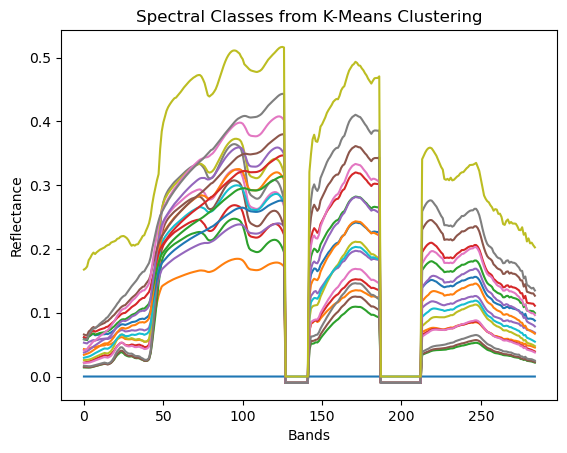

In [75]:
%matplotlib inline
import pylab
pylab.figure()
for i in range(c.shape[0]):
    pylab.plot(c[i])
pylab.show
pylab.title('Spectral Classes from K-Means Clustering')
pylab.xlabel('Bands')
pylab.ylabel('Reflectance')

This plot shows how each band contributes to the 19 different clusters

Next, display the clustering results overlaid on the original data

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (58, 34, 19)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.32921144366264343]
    G: [0.0, 0.1447889506816864]
    B: [0.0, 0.10397863388061523]
>

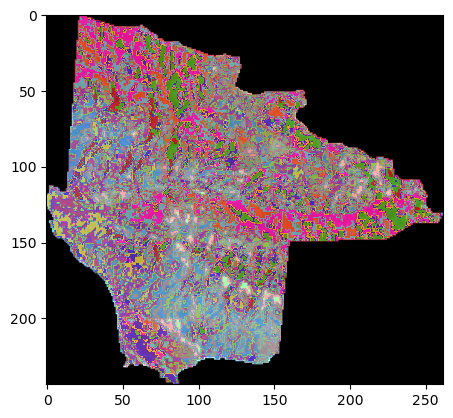

In [76]:
view = imshow(img_zero.reflectance.data, bands=(58,34,19),stretch=0.01, classes=m)
view.set_display_mode('overlay')
view.class_alpha = 0.5 #set transparency
view.show_data

This visualization helps in understanding the spatial distribution of the clusters

## Principal Component Analysis (PCA)

Perform principal component analysis on the data

In [77]:
pc = principal_components(img_zero.reflectance.data)

Create a covariance matrix of the principal components

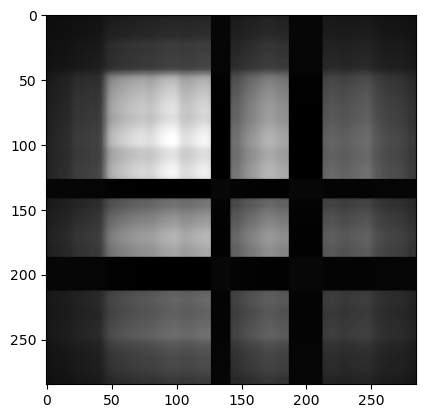

In [78]:
pc_view = imshow(pc.cov)

The covariance matrix provides insight into the relationships between different principal components

- Lighter Areas – Strong positive covariance
- Darker Areas – Strong negative covariance
- Grey Areas – Covariance near zero

Next, transform the original data using the identified principal components.

In [79]:
xdata = pc.transform(img_zero.reflectance.data)

Reduce the principal components to retain 99.9% of the variance in the data.

In [80]:
pc_0999 = pc.reduce(fraction=0.999)

Print the number of eigenvalues left after the reduction. The eigenvalues indicate the amount of variance captured by each principal component.

In [81]:
print(len(pc_0999.eigenvalues))

4


Transform the data using the reduced set of principal components and visualize it.

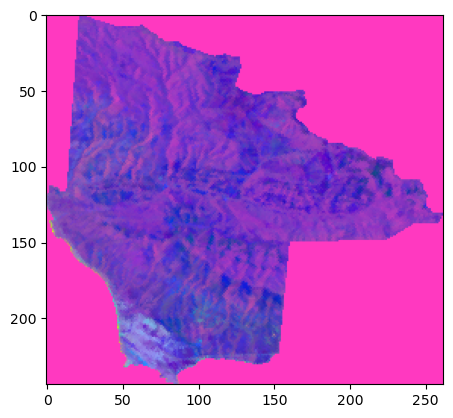

In [82]:
img_pc = pc_0999.transform(img_zero.reflectance.data)
v = imshow(img_pc[:,:,:19], stretch_all=True)

## Further Reference

For further reference, the following two resources are helpful:
1. http://www.spectralpython.net/algorithms.html#k-means-clustering
2. https://www.neonscience.org/resources/learning-hub/tutorials/classification-kmeans-pca-python